In [1]:
import numpy as np
import sys
import os
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_cellwise_df_100samplesperfile, extract_noise

In [3]:
data_path = 'C:/Users/vpming/tuni_ml/data'
all_df = build_cellwise_df_100samplesperfile(data_path)

In [4]:
min_count = all_df['dis_to_target'].value_counts().min()

n_samples = min_count

# Balance the df
df = (
    all_df.groupby('dis_to_target', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

print(df['dis_to_target'].value_counts())

dis_to_target
0    20000
1    20000
2    20000
3    20000
Name: count, dtype: int64


C:\Users\vpming\AppData\Local\Temp\ipykernel_3540\1389712327.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


In [5]:
df['noise'] = df['simulation_file'].apply(extract_noise)

In [6]:
print(df['noise'].value_counts())

noise
0.02    16162
0.01    16055
0.03    15998
0.05    15985
0.04    15800
Name: count, dtype: int64


In [7]:
x = np.stack(df['time_trace'])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3
n_bins = 4
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [8]:
class MLP(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_timepoints, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)

In [9]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [12]:
def fit(model, train_loader, test_loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/balanced_mlp_dtt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/20 Train Loss: 0.9122  Train Accuracy: 55.86%  Test Loss: 0.9501  Test Accuracy: 53.77%
Epoch 10/20 Train Loss: 0.8476  Train Accuracy: 59.60%  Test Loss: 0.9597  Test Accuracy: 54.38%
Epoch 15/20 Train Loss: 0.7970  Train Accuracy: 62.24%  Test Loss: 0.9824  Test Accuracy: 54.34%
Epoch 20/20 Train Loss: 0.7556  Train Accuracy: 64.41%  Test Loss: 1.0395  Test Accuracy: 54.07%


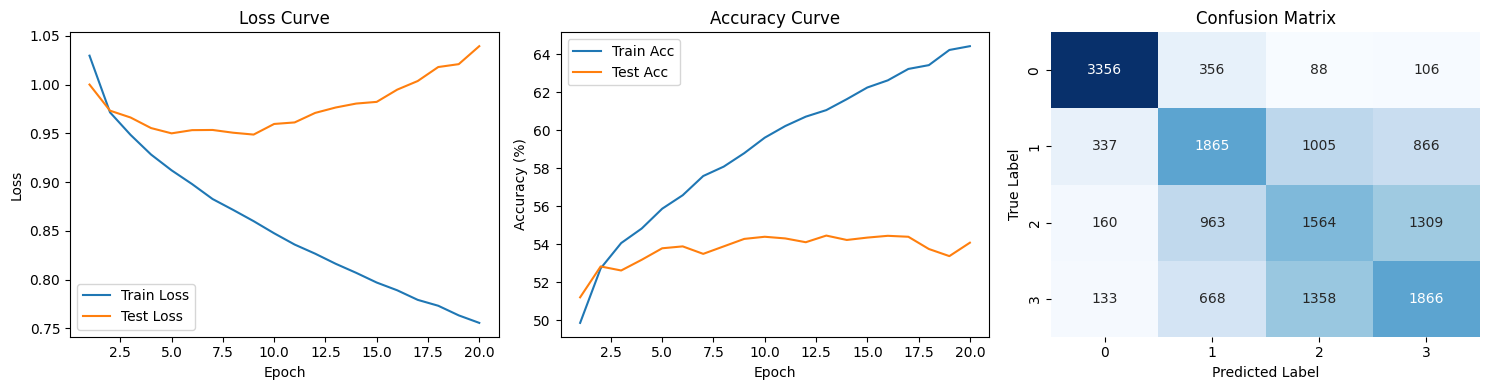

([1.0297730971574783,
  0.9715996559858322,
  0.9485418943762779,
  0.9283464609980583,
  0.9121714774370193,
  0.8980481344461441,
  0.8827087135910988,
  0.8715690760612488,
  0.8600170844197274,
  0.8475754984021187,
  0.8360024703741074,
  0.8266495751738548,
  0.8162948856949807,
  0.8069997717738151,
  0.797037655711174,
  0.7890829622149468,
  0.7792674559354782,
  0.7732243208885193,
  0.7633449106514454,
  0.7556479611396789],
 [1.0001265540122986,
  0.9733423900604248,
  0.9663528394699097,
  0.9555072445869446,
  0.950092216014862,
  0.9533752102851868,
  0.9535623109340667,
  0.9507314462661743,
  0.948829083442688,
  0.959715975522995,
  0.9612902245521545,
  0.9710533008575439,
  0.9765962874889373,
  0.9806418883800506,
  0.9823749384880066,
  0.9949206914901734,
  1.0037642278671264,
  1.0181169600486755,
  1.0210741057395936,
  1.0395201334953308],
 [49.8484375,
  52.7171875,
  54.05,
  54.8140625,
  55.8578125,
  56.5671875,
  57.578125,
  58.0734375,
  58.78125,
  59

In [13]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = MLP(n_timepoints, n_classes)

fit(model, train_loader, test_loader)


=== Training for noise 0.01 ===
Training on 12844 samples; Testing on 3211 samples
Epoch 5/15 Train Loss: 0.7092  Train Accuracy: 65.41%  Test Loss: 0.8175  Test Accuracy: 61.13%
Epoch 10/15 Train Loss: 0.6180  Train Accuracy: 71.11%  Test Loss: 0.7832  Test Accuracy: 62.88%
Epoch 15/15 Train Loss: 0.5318  Train Accuracy: 76.50%  Test Loss: 0.8740  Test Accuracy: 62.01%


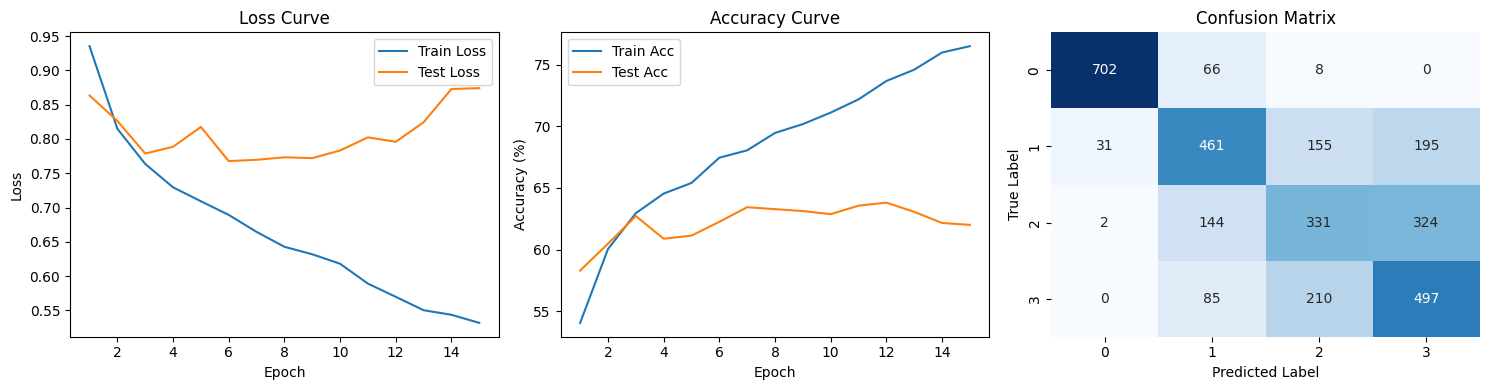


=== Training for noise 0.02 ===
Training on 12929 samples; Testing on 3233 samples
Epoch 5/15 Train Loss: 0.7811  Train Accuracy: 62.77%  Test Loss: 0.9026  Test Accuracy: 56.97%
Epoch 10/15 Train Loss: 0.6679  Train Accuracy: 69.59%  Test Loss: 0.9282  Test Accuracy: 57.81%
Epoch 15/15 Train Loss: 0.5585  Train Accuracy: 75.23%  Test Loss: 1.0932  Test Accuracy: 56.08%


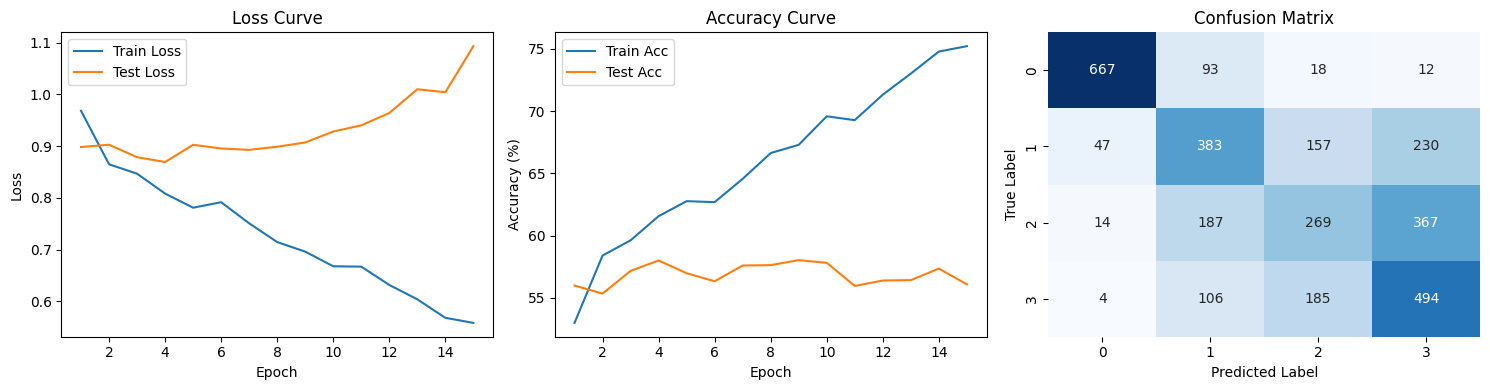


=== Training for noise 0.03 ===
Training on 12798 samples; Testing on 3200 samples
Epoch 5/15 Train Loss: 0.8618  Train Accuracy: 59.08%  Test Loss: 0.9490  Test Accuracy: 54.09%
Epoch 10/15 Train Loss: 0.7242  Train Accuracy: 67.21%  Test Loss: 1.0166  Test Accuracy: 52.91%
Epoch 15/15 Train Loss: 0.5559  Train Accuracy: 76.61%  Test Loss: 1.2310  Test Accuracy: 52.62%


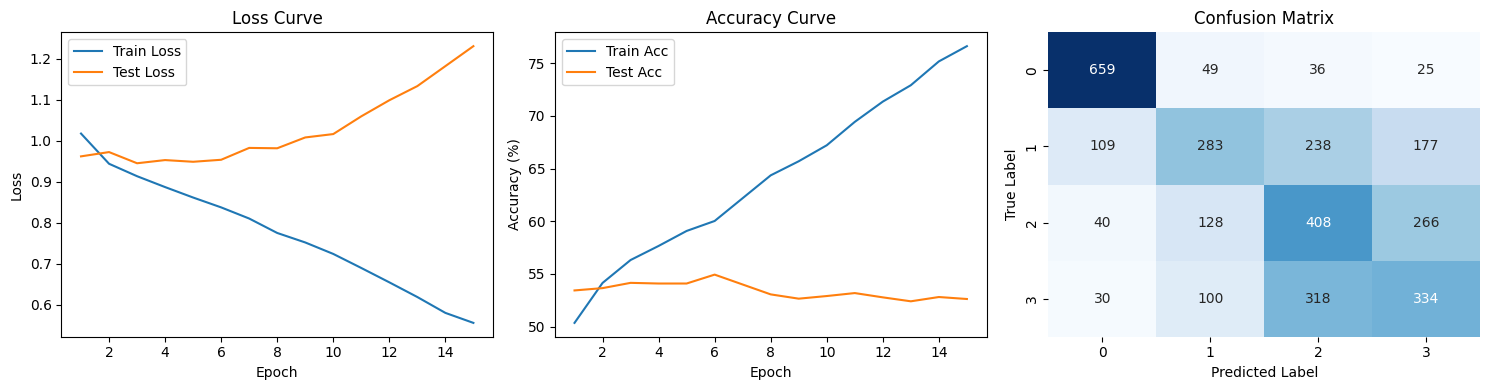


=== Training for noise 0.04 ===
Training on 12640 samples; Testing on 3160 samples
Epoch 5/15 Train Loss: 0.9509  Train Accuracy: 55.93%  Test Loss: 1.0677  Test Accuracy: 48.35%
Epoch 10/15 Train Loss: 0.7887  Train Accuracy: 64.78%  Test Loss: 1.1714  Test Accuracy: 47.44%
Epoch 15/15 Train Loss: 0.6044  Train Accuracy: 74.91%  Test Loss: 1.4512  Test Accuracy: 46.68%


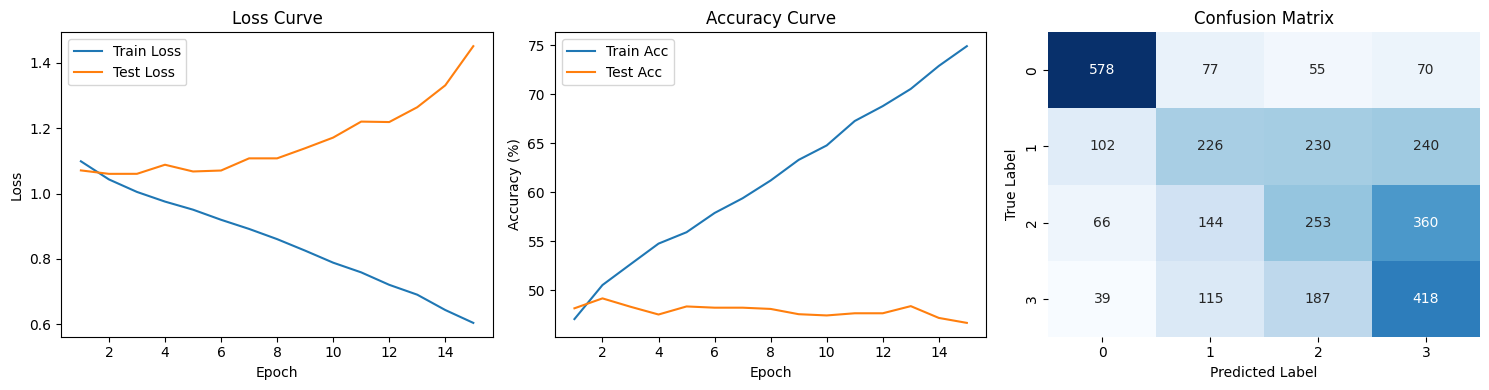


=== Training for noise 0.05 ===
Training on 12788 samples; Testing on 3197 samples
Epoch 5/15 Train Loss: 1.0130  Train Accuracy: 53.60%  Test Loss: 1.1315  Test Accuracy: 45.61%
Epoch 10/15 Train Loss: 0.8540  Train Accuracy: 62.54%  Test Loss: 1.2658  Test Accuracy: 45.79%
Epoch 15/15 Train Loss: 0.6645  Train Accuracy: 72.32%  Test Loss: 1.4882  Test Accuracy: 43.63%


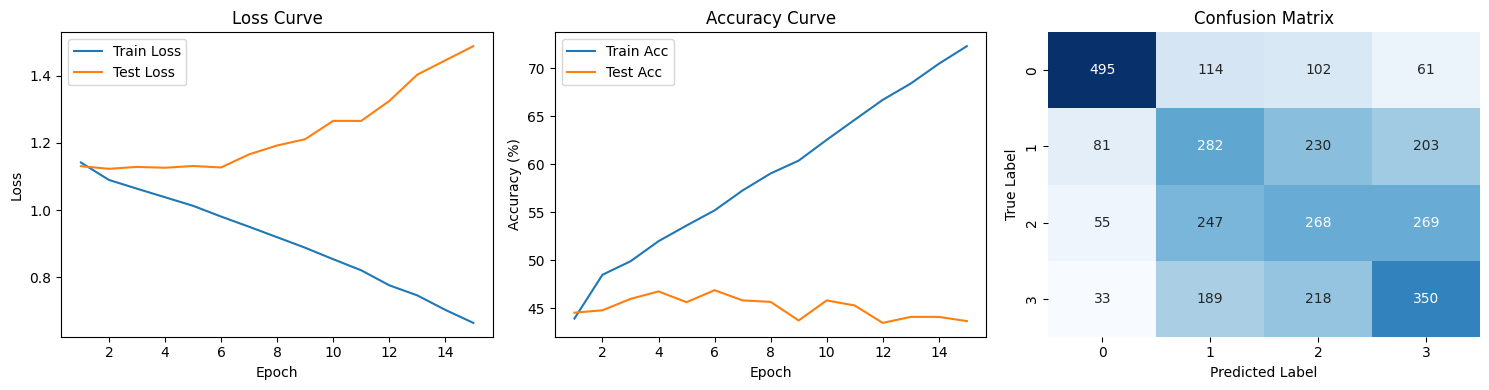

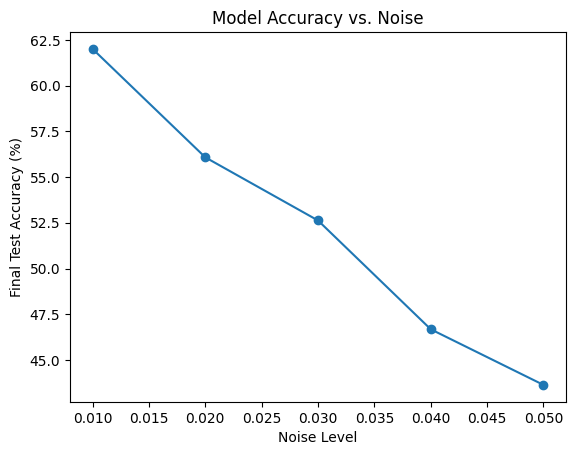

In [14]:
df['noise'] = df['simulation_file'].apply(extract_noise)

results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    X = np.stack(df.loc[mask, 'time_trace'])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 4
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = MLP(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise")
plt.show()